<a href="https://colab.research.google.com/github/natalialopezg/Monografia-EACD/blob/master/Exploratory_Data_Analysis_and_Dataset_Preperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="2">Monografía - Especialización en Analítica y Ciencia de Datos - Universidad de Antioquia - 2024</font>

<a name="polyp-segmentation:-data-exploration-and-dataset-preperation"></a>
# Polyp Segmentation: Data Exploration and Dataset Preperation

# Abstract
In this notebook the exploratory analysis of colorectal polyp images obtained from colonoscopy videos is performed. The images are part of the datasets [CVC-ColonDB](http://mv.cvc.uab.es/projects/colon-qa/cvc-colondb), [CVC-ClinicDB](https://polyp.grand-challenge.org/CVCClinicDB/), [Kvasir-SEG](https://datasets.simula.no/kvasir-seg/), [CVC-300 (EndoScene)](http://adas.cvc.uab.es/endoscene) and [ETIS-Larib](https://polyp.grand-challenge.org/ETISLarib/). The preparation of the datasets is performed as an initial step in the process for the subsequent development of the segmentation models.

# Objetive
The purpose of this notebook is to explore and understand the polyp images obtained from open data sources and to prepare the training, testing and validation datasets for the next notebook in which data preprocessing and model training is performed.

# About Datasets

In this work it is used open access datasets of gastrointestinal polyp images and the corresponding segmentation masks, available at the corresponding link.

<br>

**CVC-ColonDB**<br>
2012<br>
[Introductory article](https://doi.org/10.1016/j.patcog.2012.03.002) <br>
[Download site](http://mv.cvc.uab.es/projects/colon-qa/cvccolondb)

In this dataset, 15 random cases were used, in which experts (physicians) annotated all sequences showing polyps, and a random sample of 20 frames per sequence was obtained, with a frame size of 500×574 pixels. The central part of the images was cropped to reject non-functional black borders. The experts ensured that all these 20 frames showed a significantly different viewpoint within the scene, rejecting similar frames. Images and masks are image files with a **.png** extension.

<br>

**CVC-ClinicDB**<br>
2015<br>
[Introductory article](https://doi.org/10.1016/j.compmedimag.2015.02.007) <br>
[Download site](https://polyp.grand-challenge.org/CVCClinicDB/)

This dataset was generated in collaboration with Hospital Clinic of Barcelona, Spain, from 23 different video studies from standard colonoscopy interventions using white light. For each study all the sequences containing a polyp were extracted, providing a total number of 31 sequences of 31 different polyps. In addition, a ground truth was created by the experts by manually defining a mask on the region covered by the polyp. Images and masks are image files with a **.tiff** extension.

<br>

**Kvasir-SEG**<br>
2020<br>
[Introductory article](https://dl.acm.org/doi/10.1007/978-3-030-37734-2_37) <br>
[Download site](https://datasets.simula.no/kvasir-seg/)

This is a dataset of gastrointestinal polyp images and corresponding segmentation masks, manually annotated by a medical doctor and then verified by an experienced gastroenterologist. It is 46.2 MB in size, contains 1000 polyp images and their corresponding ground truth from the Kvasir Dataset v2. The resolution of the images contained in Kvasir-SEG varies from 332x487 to 1920x1072 pixels. The image files are encoded using JPEG compression.



# Importing libraries

## Requirements
For the correct execution of the notebook, dependencies are presented together with their versions used in the development:


    pandas==2.0.3
    numpy==1.25.2
    opencv-python==4.8.0.76
    Pillow==9.4.0
    pylibtiff==0.6.1
    matplotlib==3.7.1
    seaborn==0.13.1
    pylibtiff==0.6.1
    tqdm==4.66.2
    glob2==0.7
    zipp==3.18.1

In [1]:
!pip3 install pylibtiff

In [2]:
# Data analysis and manipulation
import pandas as pd
import numpy as np
import json

# Computer vision
import cv2
from PIL import Image
from libtiff import TIFF

# Progress meter for loops
from tqdm.notebook import tqdm

# Image and graphs visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Dataset preparation
from sklearn.model_selection import train_test_split

# Miscellaneous operating system interfaces
import os
import zipfile
from glob import glob
import shutil


# Function definition

In [3]:
def load_dataset(file_id,folder_name):
  """
    Downloads and extracts the dataset from the given file ID to the specified folder.

    Args:
        file_id (str): The ID of the file to be downloaded.
        folder_name (str): The name of the folder to save the dataset.

    Returns:
        tuple: A tuple containing paths to the dataset directory, images directory, and masks directory.
  """
  # Download the zip file
  output_path = f"/tmp/{folder_name}.zip"
  !gdown {file_id} -O {output_path}

  # Extract data from zip
  local_zip = f"/tmp/{folder_name}.zip"
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/tmp')
  zip_ref.close()

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{folder_name}"
  images_dir = os.path.join(data_dir, "images")
  masks_dir = os.path.join(data_dir, "masks")

  return data_dir, images_dir, masks_dir

def get_bounding_boxes(mask_image):
  """
    Finds contours in the mask image and calculates bounding boxes for each contour.

    Args:
        mask_image (numpy.ndarray): The mask image containing contours.

    Returns:
        list: A list of dictionaries containing the coordinates of bounding boxes.
  """
  # Find contours in the mask image
  contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Initialize list to store bounding boxes
  bounding_boxes = []

  # Iterate through contours
  for contour in contours:
      # Get bounding box coordinates
      x, y, w, h = cv2.boundingRect(contour)
      if w > 10 and h > 10:
        # Append bounding box coordinates to list
        bounding_boxes.append({"xmin": int(x), "ymin": int(y), "xmax": int(x + w), "ymax": int(y + h)})

  return bounding_boxes

def plot_dataset_images(image_colon,image_clinic,image_kvasir, title):
  """
    Plots three images from different datasets with their respective titles.

    Args:
        image_colon (numpy.ndarray): Image data from the cvc-colondb dataset.
        image_clinic (numpy.ndarray): Image data from the cvc-clinicdb dataset.
        image_kvasir (numpy.ndarray): Image data from the kvasir-seg dataset.
        title (str): Title for the plot.

    Returns:
        None
  """
  fig, axes = plt.subplots(1,3, figsize=(10, 6))

  axes[0].imshow(image_colon)
  axes[1].imshow(image_clinic)
  axes[2].imshow(image_kvasir)

  axes[0].grid(False)
  axes[1].grid(False)
  axes[2].grid(False)

  axes[0].set_title(f"cvc-colondb\n{image_colon.shape}")
  axes[1].set_title(f"cvc-clinicdb\n{image_clinic.shape}")
  axes[2].set_title(f"kvasir-seg\n{image_kvasir.shape}")

  fig.tight_layout()
  fig.suptitle(title, fontsize=16, fontweight='bold', y=0.8)
  plt.show()

def polyps_position(bounding_boxes):
  """
    Calculates the distribution of polyps across a 3x3 grid based on bounding box coordinates.

    Args:
        bounding_boxes (dict): Dictionary containing bounding box data.

    Returns:
        tuple: A tuple containing x-position values and counts of polyps in each grid cell.
  """
  # Initialize a 3x3 grid to store the grid counts
  grid_counts = [[0] * 3 for _ in range(3)]

  # Iterate over the bounding box data
  for image_data in bounding_boxes.values():
      height = image_data['height']
      width = image_data['width']
      for bbox in image_data['bbox']:
          # Extract the coordinates
          xmin = bbox['xmin']
          ymin = bbox['ymin']
          xmax = bbox['xmax']
          ymax = bbox['ymax']

          # Calculate the center coordinates
          x_center = (xmin + xmax) / 2
          y_center = (ymin + ymax) / 2

          # Determine the grid cell based on the center coordinates
          grid_row = int(y_center / (height / 3))
          grid_col = int(x_center / (width / 3))

          # Increment the count for the corresponding grid cell
          grid_counts[grid_row][grid_col] += 1

  # Flatten the grid counts into a 1D list
  counts = [count for row in grid_counts for count in row]

  # Create a bar chart
  x_pos = np.arange(len(labels))

  return x_pos, counts

def polyps_relative_size(bounding_boxes):
  """
    Calculates the relative sizes of polyps in the dataset.

    Args:
        bounding_boxes (dict): Dictionary containing bounding box data.

    Returns:
        list: A list of relative sizes of polyps.
  """
  # Empty list to store all the relative sizes
  relative_sizes = []

  # Iterate over the bounding box data
  for image_data in bounding_boxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        # Calculate the area of the bounding box
        bbox_area = bbox_width * bbox_height

        # Calculate the area of the image
        image_area = height * width

        # Calculate the relative size of the bounding box
        relative_size = bbox_area / image_area

        # Append the relative size to the list
        relative_sizes.append(relative_size)

  return relative_sizes

def hsv_values(images_files,images_dir):
  """
    Calculates the average brightness, hue, and saturation of images in the specified directory.

    Args:
        images_files (list): List of image files in the directory.
        images_dir (str): Path to the directory containing images.

    Returns:
        tuple: A tuple containing lists of brightness values, hue values, and saturation values.
  """
  # Calculate the average brightness, hue, and saturation of the images
  brightness_values = []
  hue_values = []
  saturation_values = []

  # Create a progress bar for the loop
  for image_file in tqdm(images_files, position = 1,desc=f"{images_dir.split('/')[2]}"):
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)
  return brightness_values, hue_values, saturation_values

# Load Datasets

In [4]:
# Delete previously created datasets
folder_path = '/tmp/cvc-clinicdb'
if os.path.exists(folder_path):
  shutil.rmtree(folder_path)

folder_path = '/tmp/cvc-colondb'
if os.path.exists(folder_path):
  shutil.rmtree(folder_path)

folder_path = '/tmp/kvasir-seg'
if os.path.exists(folder_path):
  shutil.rmtree(folder_path)

<a name="verify-file-format-and-quantity"></a>
## Verify file format and quantity
The compressed files are downloaded and unzipped. It is also checked that the count and format of the images and masks match.

In [5]:
# Dataset names
datasets = ['cvc-colondb', 'cvc-clinicdb', 'kvasir-seg']

# File IDs for download from drive
file_ids = ['1uVfE6zqmncp7GYEUvGk77D_9MqqRIBtr', '19Cvn0dz1-Hm06t6J4QqmNjVgio-cBgJd', '1m-GSaHnY7rKjZBS09i9wEwz96Ah7tTdD']

datasets_df = pd.DataFrame()

for file_id,folder_name in zip(file_ids,datasets):

  print (f"Dataset: {folder_name}\n{'--'*15}")

  # Download and extract data from zip
  data_dir, images_dir, masks_dir = load_dataset(file_id,folder_name)

  # Get a list of filenames in the "images" and "masks" subdirectories
  images_files = os.listdir(images_dir)
  masks_files = os.listdir(masks_dir)

  datasets_df = pd.concat([datasets_df,pd.DataFrame({'dataset':folder_name, 'count_img': len(images_files)}, index = [0])])

  print("Unzipped!")

  # Images folder processing
  images_formats = set()
  for i,file_name in enumerate(images_files):
      file_path = os.path.join(images_dir, file_name)
      # Check the file format of each image file in the images folder
      if os.path.isfile(file_path):
          file_format = file_name.split(".")[-1]
          images_formats.add(file_format)

  # Mask folder processing
  masks_formats = set()
  for i,file_name in enumerate(masks_files):
      file_path = os.path.join(masks_dir, file_name)
      # Check the file format of each image file in the masks folder
      if os.path.isfile(file_path):
          file_format = file_name.split(".")[-1]
          masks_formats.add(file_format)

  # Print the number of images and masks, along with their file formats
  print("Verification of file format and quantity:")
  print(f"-There are {len(images_files)} colonoscopic images with {images_formats} formats")
  print(f"-There are {len(masks_files)} segmentation masked images with {masks_formats} formats\n")

datasets_df = datasets_df.reset_index(drop=True)

Dataset: cvc-colondb
------------------------------
Downloading...
From (original): https://drive.google.com/uc?id=1uVfE6zqmncp7GYEUvGk77D_9MqqRIBtr
From (redirected): https://drive.google.com/uc?id=1uVfE6zqmncp7GYEUvGk77D_9MqqRIBtr&confirm=t&uuid=21ed71f7-eb36-472a-ae4a-c812a98a501a
To: /tmp/cvc-colondb.zip
100% 95.7M/95.7M [00:00<00:00, 131MB/s]
Unzipped!
Verification of file format and quantity:
-There are 380 colonoscopic images with {'png'} formats
-There are 380 segmentation masked images with {'png'} formats

Dataset: cvc-clinicdb
------------------------------
Downloading...
From (original): https://drive.google.com/uc?id=19Cvn0dz1-Hm06t6J4QqmNjVgio-cBgJd
From (redirected): https://drive.google.com/uc?id=19Cvn0dz1-Hm06t6J4QqmNjVgio-cBgJd&confirm=t&uuid=5e3d89cb-cc54-43ca-a824-920e19c0c9a0
To: /tmp/cvc-clinicdb.zip
100% 84.4M/84.4M [00:00<00:00, 156MB/s]
Unzipped!
Verification of file format and quantity:
-There are 612 colonoscopic images with {'tif'} formats
-There are 612 seg

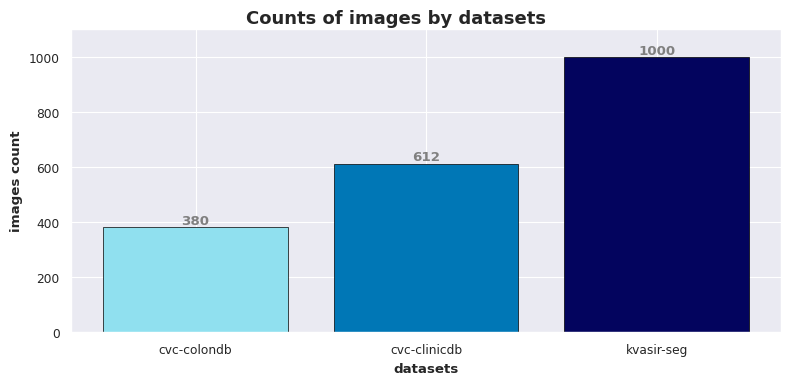

In [6]:
# @title
#set seaborn plotting aesthetics as default
sns.set(context="paper", style='darkgrid')
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

axes.bar(x =datasets_df['dataset'],
         height= datasets_df['count_img'],
         color = ['#90e0ef','#0077b6','#03045e'],
         edgecolor = 'black',
         linewidth = 0.5)

for bars in axes.containers:
  axes.bar_label(bars, fmt='%.0f',fontweight = "bold", color ='gray')

axes.margins(y=0.1)

axes.set_xlabel("datasets", fontweight = "bold" )
axes.set_ylabel("images count", fontweight = "bold")

fig.tight_layout()
plt.subplots_adjust(top = 0.9)

fig.suptitle("Counts of images by datasets", fontsize = 13, fontweight = "bold", y= 0.95);

The kvasir-seg dataset is the most complete. The sum of the other data sets is approximately equal to the number of the kavasir-seg dataset.

<a name="File renaming and format conversion"></a>
## File renaming and format conversion
The files are renamed because the original file names for both images and masks are the same, this could cause confusion. Images with a format other than “jpg” are converted.

In [7]:
# Define a dictionary to map the original filenames to new filenames
name_mapping = {"images": "image_", "masks": "mask_"}

for dataset in tqdm(datasets, desc="Datasets read", position=0, colour='#6c757d'):

  print (f"\nDataset: {dataset}\n{'--'*12}")

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{dataset}"
  images_dir = os.path.join(data_dir, "images")
  masks_dir = os.path.join(data_dir, "masks")

  # Get a list of filenames in the "images" and "masks" subdirectories
  images_files = os.listdir(images_dir)
  masks_files = os.listdir(masks_dir)

  # Rename the files in the "images" subdirectory
  for i, file_name in enumerate(tqdm(images_files, \
                           desc=f"  Images read", \
                           position=1, colour='#adb5bd')):
    old_file_path = os.path.join(images_dir, file_name)
    new_file_name = f"{name_mapping['images']}{dataset.split('-')[-1]}_{i+1:04d}.jpg"
    new_file_path = os.path.join(images_dir, new_file_name)
    if os.path.isfile(file_path):
      file_format = file_name.split(".")[-1]
      if file_format != "jpg":
        if file_format == "tif":
          tiff_image = TIFF.open(old_file_path).read_image()
          convert_image = Image.fromarray(tiff_image)
        else:
          convert_image = Image.open(old_file_path)
        convert_image.save(new_file_path, 'JPEG')
        convert_image.close()
        os.remove(old_file_path)
      else:
        os.rename(old_file_path, new_file_path)

  # Rename the files in the "masks" subdirectory
  for i, file_name in enumerate(tqdm(masks_files, \
                           desc=f"  Masks read", \
                           position=1, colour='#83c5be')):
      old_file_path = os.path.join(masks_dir, file_name)
      new_file_name = f"{name_mapping['masks']}{dataset.split('-')[-1]}_{i+1:04d}.jpg"
      new_file_path = os.path.join(masks_dir, new_file_name)
      if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        if file_format != "jpg":
          if file_format == "tif":
            tiff_image = TIFF.open(old_file_path).read_image()
            convert_image = Image.fromarray(tiff_image)
          else:
            convert_image = Image.open(old_file_path)
          convert_image.save(new_file_path, 'JPEG')
          convert_image.close()
          os.remove(old_file_path)
        else:
          os.rename(old_file_path, new_file_path)

Datasets read:   0%|          | 0/3 [00:00<?, ?it/s]


Dataset: cvc-colondb
------------------------


  Images read:   0%|          | 0/380 [00:00<?, ?it/s]

  Masks read:   0%|          | 0/380 [00:00<?, ?it/s]


Dataset: cvc-clinicdb
------------------------


  Images read:   0%|          | 0/612 [00:00<?, ?it/s]

  Masks read:   0%|          | 0/612 [00:00<?, ?it/s]


Dataset: kvasir-seg
------------------------


  Images read:   0%|          | 0/1000 [00:00<?, ?it/s]

  Masks read:   0%|          | 0/1000 [00:00<?, ?it/s]

<a name="Bounding-box-generation"></a>
## Bounding box generation

To analyze the position and size of the polyps with respect to the image, the bounding boxes are generated to a json file.

In [8]:
for dataset in tqdm(datasets, desc="Datasets read", position=0, colour='#6c757d'):

  print(f"\nDataset: {dataset}\n{'--'*12}")

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{dataset}"
  masks_dir = os.path.join(data_dir, "masks")

  # Get a list of filenames in the "images" and "masks" subdirectories
  masks_files = os.listdir(masks_dir)

  # Initialize list to store bounding box information for all images
  all_bounding_boxes = {}

  # Rename the files in the "masks" subdirectory
  for i, file_name in enumerate(masks_files):
    # Load the mask image
    mask_image = cv2.imread(os.path.join(masks_dir, file_name), cv2.IMREAD_GRAYSCALE)

    # Get bounding boxes for the current mask image
    bounding_boxes = get_bounding_boxes(mask_image)

    # Get image height and width
    height, width = mask_image.shape[:2]

    # Store bounding box information for the current image
    all_bounding_boxes[file_name[:-4]] = {"height": height, "width": width, "bbox": bounding_boxes}

  # Save bounding box information to JSON file
  with open(f'{data_dir}/bounding_boxes.json', 'w') as json_file:
      json.dump(all_bounding_boxes, json_file)

  print(f"Bounding box information saved to {data_dir}/bounding_boxes.json")


Datasets read:   0%|          | 0/3 [00:00<?, ?it/s]


Dataset: cvc-colondb
------------------------
Bounding box information saved to /tmp/cvc-colondb/bounding_boxes.json

Dataset: cvc-clinicdb
------------------------
Bounding box information saved to /tmp/cvc-clinicdb/bounding_boxes.json

Dataset: kvasir-seg
------------------------
Bounding box information saved to /tmp/kvasir-seg/bounding_boxes.json


<a name="explore-image-data"></a>
# Explore Image Data

<a name="Image-basic-components"></a>
## Image basic components

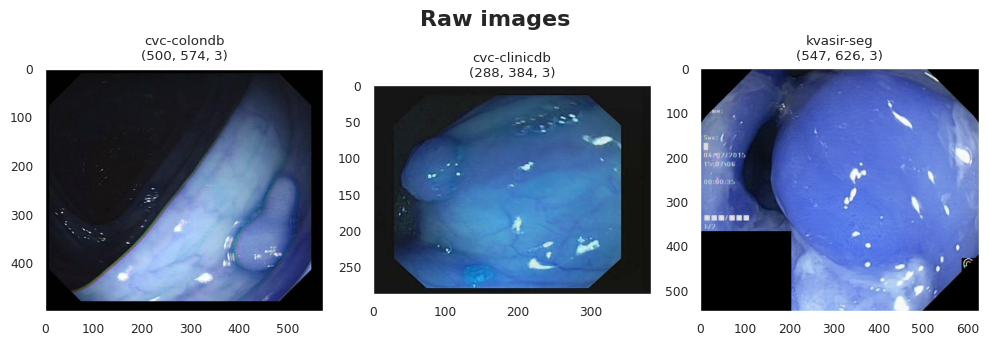

In [9]:
image_colon = cv2.imread('/tmp/cvc-colondb/images/image_colondb_0001.jpg')
image_clinic = cv2.imread('/tmp/cvc-clinicdb/images/image_clinicdb_0001.jpg')
image_kvasir = cv2.imread('/tmp/kvasir-seg/images/image_seg_0001.jpg')

plot_dataset_images(image_colon,image_clinic,image_kvasir, "Raw images")

The *cv2.imread()* method of the **OpenCV** library loads the images as color image, 3 channels, BGR by default. That's why it looks blue. Let's convert to RGB and visualize again.

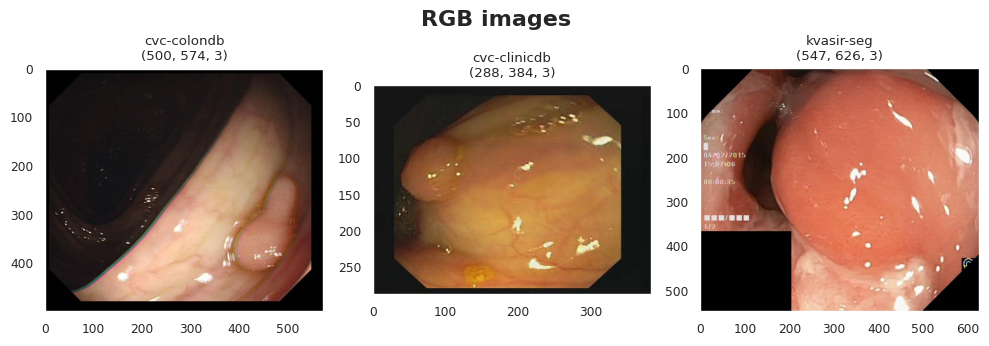

In [10]:
# @title
RGB_image_colon  = cv2.cvtColor(cv2.imread('/tmp/cvc-colondb/images/image_colondb_0001.jpg'), cv2.COLOR_BGR2RGB)
RGB_image_clinic = cv2.cvtColor(cv2.imread('/tmp/cvc-clinicdb/images/image_clinicdb_0001.jpg'), cv2.COLOR_BGR2RGB)
RGB_image_kvasir = cv2.cvtColor(cv2.imread('/tmp/kvasir-seg/images/image_seg_0001.jpg'), cv2.COLOR_BGR2RGB)

plot_dataset_images(RGB_image_colon,RGB_image_clinic,RGB_image_kvasir, "RGB images")

Now it looks like the natural color. Let's see its masks.

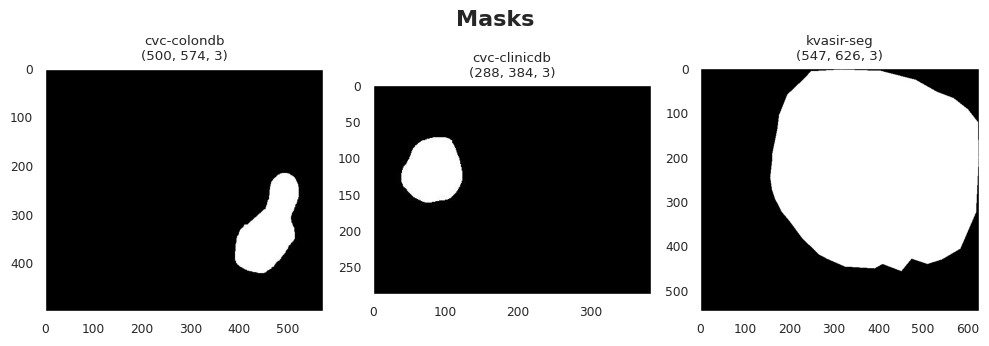

In [11]:
# @title
mask_colon  = cv2.imread('/tmp/cvc-colondb/masks/mask_colondb_0001.jpg')
mask_clinic = cv2.imread('/tmp/cvc-clinicdb/masks/mask_clinicdb_0001.jpg')
mask_kvasir = cv2.imread('/tmp/kvasir-seg/masks/mask_seg_0001.jpg')

plot_dataset_images(mask_colon,mask_clinic,mask_kvasir, "Masks")

Although the mask images look like grayscale or 1-channel images, they have 3 channels with the same values for all three channels (r, g, b) in each pixel.

In [12]:
#Find out the min and max values of pixels in the RGB image
print('RGB Image:')
print('Image minimum value: ',RGB_image_colon.min())
print('Image maximum value: ',RGB_image_colon.max())

#Find out the min and max values of pixels in the mask image
print('\nMask Image:')
print('Image minimum value: ',mask_colon.min())
print('Image maximum value: ',mask_colon.max())

RGB Image:
Image minimum value:  0
Image maximum value:  255

Mask Image:
Image minimum value:  0
Image maximum value:  255


Both the RGB and mask have the same minimum and maximum pixel value. The minimum pixel value in the image is 0 which represents black and the maximum pixel value of 255 represents white. When loading the image, we have a dtype of uint8 (unsigned), so the pixel intensity values range have $2^8$ values or 256 values to work with. Because it is unsigned, it does not have negative values.

Later when it coms to data preprocessing, we will rescale the data by dividing it by the maximum pixel value (255) before applying it to ensure that the data falls within a similar range and has a consistent scale, which can improve the performance and convergence of the model.

<a name="Width-and-height"></a>
## Image width and height

Check if the image and its corresponding mask have the same size (e.g. image size1 = mask size1).

In [13]:
# @title
for folder_name in datasets:

  print (f"\nDataset: {folder_name}\n{'--'*12}")

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{folder_name}"
  images_dir = os.path.join(data_dir, "images")
  masks_dir = os.path.join(data_dir, "masks")

  # Get a list of filenames in the "images" and "masks" subdirectories
  images_files = os.listdir(images_dir)
  masks_files = os.listdir(masks_dir)
  images_files.sort()
  masks_files.sort()

  # Empty list to store Booleans of whether or not the size of images and masks are equal
  bool_size = []

  # Iterate over the image and mask files simultaneously
  for image_file, mask_file in zip(images_files, masks_files):
      # Get the paths to the image and mask files
      image_path = os.path.join(images_dir, image_file)
      mask_path = os.path.join(masks_dir, mask_file)

      # Open the image and mask files
      with Image.open(image_path) as image, Image.open(mask_path) as mask:
          # Get the dimensions of the image and mask
          image_size = image.size
          mask_size = mask.size

          # Compare the dimensions
          if image_size == mask_size:
              bool_size.append(True)
          else:
              bool_size.append(False)

  # Check if all elements are True
  print(f"{all(bool_size)}, both images and masks have the same size.")

  exec(f"heights_{folder_name.split('-')[-1]} = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[0] for idx in range(len(images_files))]")
  exec(f"widths_{folder_name.split('-')[-1]} = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[1] for idx in range(len(images_files))]")


Dataset: cvc-colondb
------------------------
True, both images and masks have the same size.

Dataset: cvc-clinicdb
------------------------
True, both images and masks have the same size.

Dataset: kvasir-seg
------------------------
True, both images and masks have the same size.


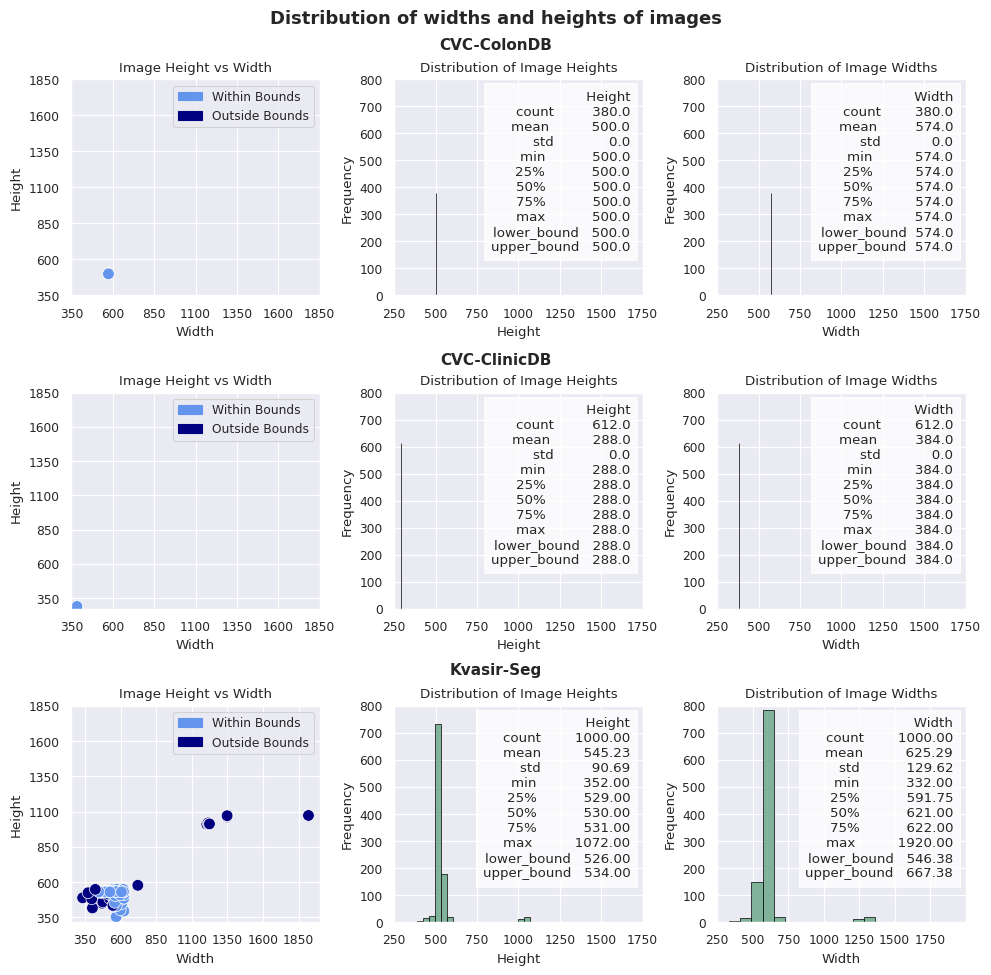

In [14]:
# @title
heights_datasets = [heights_colondb, heights_clinicdb, heights_seg]
widths_datasets = [widths_colondb, widths_clinicdb, widths_seg]

# Create a figure with two subplots and a scatter plot
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i,(heights,widths) in enumerate(zip(heights_datasets,widths_datasets)):
  # Create a DataFrame with heights and widths
  df = pd.DataFrame({'Height': heights, 'Width': widths})

  # Generate the summary statistics
  summary = round(df.describe(), 2)

  # Calculate the lower bound and upper bound
  q1 = summary.loc['25%']
  q3 = summary.loc['75%']
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  # Add the lower bound and upper bound to the summary
  summary.loc['lower_bound'] = round(lower_bound,2)
  summary.loc['upper_bound'] = round(upper_bound,2)

  # Plot the scatter plot of heights and widths
  colors = np.where((heights >= lower_bound['Height']) & (heights <= upper_bound['Height']) |
                    (widths >= lower_bound['Width']) & (widths <= upper_bound['Width']), 'cornflowerblue', 'navy')

  scatter = axs[i,0].scatter(widths, heights, c=colors, edgecolor='white', linewidth=0.5, s = 70 )
  axs[i,0].set_xlabel('Width')
  axs[i,0].set_ylabel('Height')
  axs[i,0].set_title('Image Height vs Width')
  axs[i,0].set_xticks(np.arange(350, 1920, 250))
  axs[i,0].set_yticks(np.arange(350, 1920, 250))

  # Create legend labels
  legend_labels = [mpatches.Patch(color='cornflowerblue', label='Within Bounds'),
                  mpatches.Patch(color='navy', label='Outside Bounds')]

  # Add legend
  axs[i,0].legend(handles=legend_labels)

  # Plot the histogram of heights
  axs[i,1].hist(heights, bins=20, color = '#81b29a', edgecolor='black', linewidth=0.5)
  axs[i,1].set_xlabel('Height')
  axs[i,1].set_ylabel('Frequency')
  axs[i,1].set_title('Distribution of Image Heights')
  axs[i,1].set_xticks(np.arange(250, 1920, 250))
  axs[i,1].text(0.95, 0.95, str(summary[['Height']]), transform=axs[i,1].transAxes,
              verticalalignment='top', horizontalalignment='right',
              bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

  # Plot the histogram of widths
  axs[i,2].hist(widths, bins=20, color = '#81b29a', edgecolor='black', linewidth=0.5)
  axs[i,2].set_xlabel('Width')
  axs[i,2].set_ylabel('Frequency')
  axs[i,2].set_title('Distribution of Image Widths')
  axs[i,2].text(0.95, 0.95,
              str(summary[['Width']]),
              transform=axs[i,2].transAxes,
              verticalalignment='top', horizontalalignment='right',
              bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
  axs[i,2].set_xticks(np.arange(250, 1920, 250))

  # Set the same vertical scale for both histograms
  axs[i,1].set_ylim([0, 800])
  axs[i,2].set_ylim([0, 800])



# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace= 0.45 , wspace= 0.3)

fig.suptitle("Distribution of widths and heights of images", fontsize = 13, fontweight = "bold", y= 0.97);
plt.figtext(0.5, 0.935,"CVC-ColonDB", va="center", ha="center", size=11, fontweight = "bold")
plt.figtext(0.5, 0.62,"CVC-ClinicDB", va="center", ha="center", size=11, fontweight = "bold")
plt.figtext(0.5, 0.31,"Kvasir-Seg", va="center", ha="center", size=11, fontweight = "bold")

# Display the plot
plt.show()

The **CVC-ColonDB** and **CVC-ClinicDB** datasets have standardized dimensions, while **Kvasir-SEG** has different image sizes.

The image sizes of the **Kvasir-SEG** dataset range from 332x487 to 1920x1072 pixels. Both width and height are skewed to the right and there are some extreme outliers at the extremes of height and width.

To calculate the outliers, the lower bound and upper bound are first calculated using the interquartile range (IQR). The IQR is obtained by subtracting the 25th percentile (Q1) from the 75th percentile (Q3). The lower limit is calculated as Q1 - 1.5 * IQR, and the upper limit as Q3 + 1.5 * IQR.

Later, we will need to resize all images to the same size before fitting them to a model so that they are compatible with the model architecture.

<a name="Polyp-positions"></a>
## Polyp positions

Using the coordinates of the mask bounding boxes generated above, we will observe in which region the polyps are normally found. The image will be divided into 9 grids, we then iterate over the bounding box data, calculate the center coordinates and determine the grid cell for each bounding box based on the center coordinates.


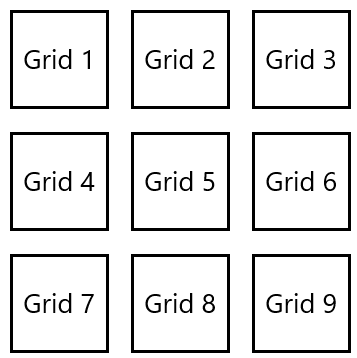

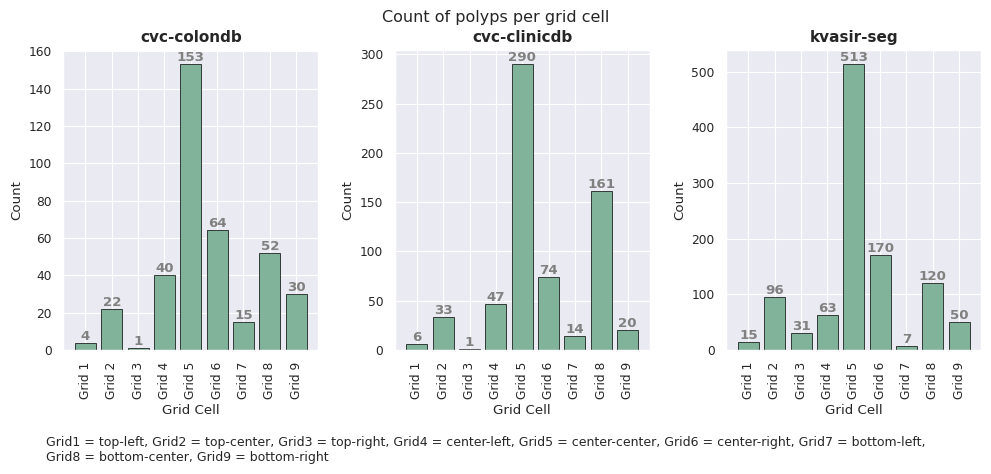

In [15]:

fig, axes = plt.subplots(1,3, figsize= (10,5))

# Define the labels for the grid cells
labels = ['Grid {}'.format(i+1) for i in range(9)]

for i,dataset in enumerate(datasets):

  with open(f'/tmp/{dataset}/bounding_boxes.json', 'r') as json_file:
      bounding_boxes = json.load(json_file)

  x_pos, counts = polyps_position(bounding_boxes)
  axes[i].bar(x_pos, counts, align='center', color = '#81b29a', edgecolor ='black', linewidth = 0.5)

  for bars in axes[i].containers:
    axes[i].bar_label(bars, fmt='%.0f',fontweight = "bold", color ='gray')

  # Set the axis labels and title
  axes[i].set_xlabel('Grid Cell')
  axes[i].set_ylabel('Count')
  axes[i].set_title(dataset,size=11, fontweight = "bold")

  # Set the x-axis tick labels
  axes[i].set_xticks(x_pos)
  axes[i].set_xticklabels(labels, rotation = 90, ha="center")

fig.suptitle('Count of polyps per grid cell')
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace= 0.3 , wspace= 0.3, bottom = 0.3)

plt.figtext(0.05, 0.1,"Grid1 = top-left, Grid2 = top-center, Grid3 = top-right, Grid4 = center-left, Grid5 = center-center, Grid6 = center-right, Grid7 = bottom-left, \nGrid8 = bottom-center, Grid9 = bottom-right",
            va="center", ha="left", size=9, wrap =True)
plt.show()

It can be seen that most of the polyps are located in the center of the image for three data sets.

It is possible to generalize the position of the polyps with position magnification techniques, such as rotations, flips and translations.

<a name="Polyp-size-and-count"></a>
## Polyp size and count

We can get an idea of the size of the polyp by calculating the relative size of a bounding box by dividing the area of the bounding box by the total area of the image.

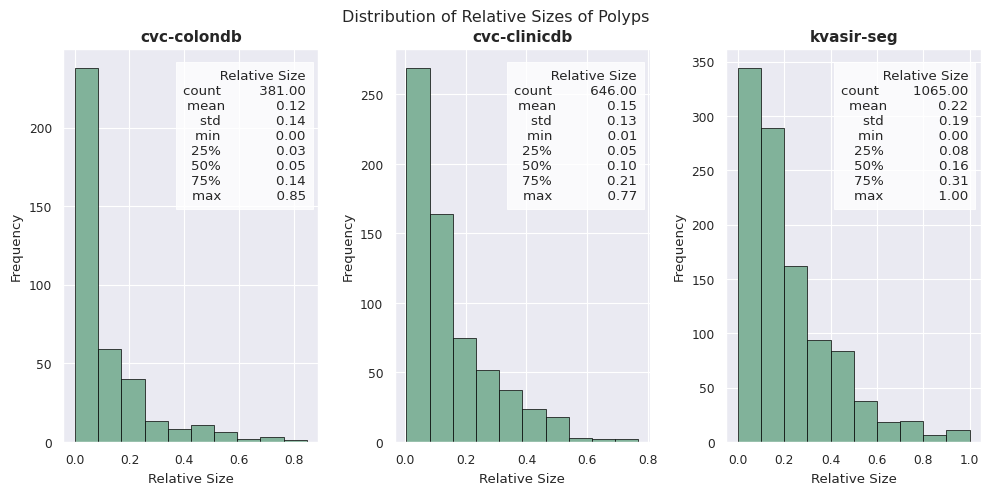

In [16]:

fig, axes = plt.subplots(1,3, figsize= (10,5))

for i,dataset in enumerate(datasets):

  with open(f'/tmp/{dataset}/bounding_boxes.json', 'r') as json_file:
      bounding_boxes = json.load(json_file)

  relative_sizes = polyps_relative_size(bounding_boxes)

    # Calculate the summary statistics
  summary = pd.DataFrame({'Relative Size': relative_sizes}).describe().round(2)

  # Plot the histogram of relative sizes
  n, bins, patches = axes[i].hist(relative_sizes, align='mid', color = '#81b29a', edgecolor ='black', linewidth = 0.5)
  axes[i].set_xlabel('Relative Size')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(dataset,size=11, fontweight = "bold")

  # Add the summary statistics to the plot as text annotations
  summary_text = str(summary[['Relative Size']])
  axes[i].text(0.95, 0.95,
          summary_text,
          transform=axes[i].transAxes,
          ha='right', va='top',
          bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

fig.suptitle('Distribution of Relative Sizes of Polyps')
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace= 0.3 , wspace= 0.3)

plt.show()


Most relative sizes are concentrated below 0.30, which means that most polyps occupy less than 30% of the entire image. There are very few images with polyps occupying more than 50% (or more) of the image.
The Kvasir-Seg dataset has a slightly more regular distribution of polyp size, the other datasets concentrate more small polyps.

We can also observe that the polyp count is higher than the total number of images, this is due to the fact that some images contain more than one polyp.

<a name="Image-hue,-brightnesss,-and-saturation"></a>
## Image hue, brightnesss, and saturation

Describing colors using hue, saturation and brightness (also at times referred to as hue, saturation and lightness, or HSL) is a convenient way to organize differences in colors as perceived by humans. Explanation to each of the categories are:

HUE - Hue refers to the pure state of color. It is the natural color without mixing or modifying. The unmixed or unmodified property of color is Hue. In other words, Hue is the name by which we identify a color. Also Hue is the property by which we distinguish it from other colors.

BRIGHTNESS (value) - Value is the relative darkness or lightness of a color. This can be illustrated by the evidence of black and white photography of colored objects. The different colors will have different tonal values. A scale which shows the sequence in tonal values of colors ( from White to Gray to Black) is called the GRAY SCALE. The tonal value of each color can be further affected by adding either black or white. The gradual adding of black color produces 'shades'. The gradual adding of white color produces 'Tints'. Maximum addition of white gives high tonal value. The middle colors between high and low is known as middle tones or half tone.

SATURATION (intensity) - Chrome or saturation which indicates the purity of color is known as the intensity. Colors which are mixed and have ultimate degree of vividness are said to exhibit 'high intensity'. Two colors may have same hue value but yet differ in color strength.

In OpenCV, Hue has values from 0 to 180, Saturation and Value from 0 to 255. Thus, OpenCV uses HSV ranges between (0-180, 0-255, 0-255). In OpenCV, the H values 179, 178, 177 and so on are as close to the true RED as H value 1, 2, 3 and so on. Below is an example of HSV color map:

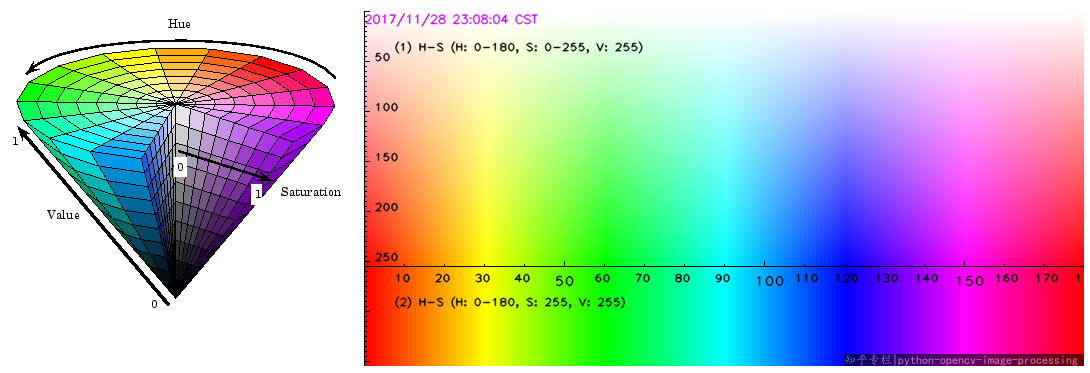

Let's plot histograms and see how are the three color components distributed for all of our RGB images

Datasets read:   0%|          | 0/3 [00:00<?, ?it/s]

cvc-colondb:   0%|          | 0/380 [00:00<?, ?it/s]

cvc-clinicdb:   0%|          | 0/612 [00:00<?, ?it/s]

kvasir-seg:   0%|          | 0/1000 [00:00<?, ?it/s]

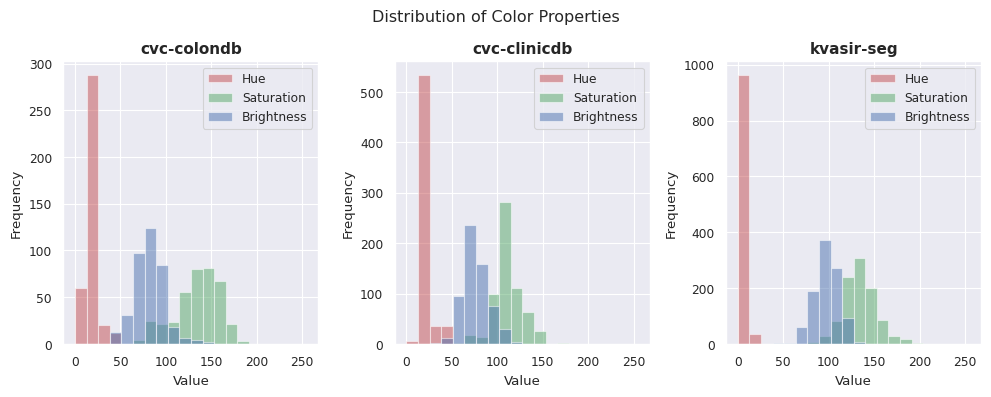

In [17]:
fig, axes = plt.subplots(1,3, figsize= (10,4))
# Set the same range for the x-axis
x_axis_range = (0, 255)  # Adjust this range as per your requirement

for i,dataset in enumerate(tqdm(datasets, desc="Datasets read", position=0, colour='#6c757d')):

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{dataset}"
  images_dir = os.path.join(data_dir, "images")
  masks_dir = os.path.join(data_dir, "masks")

  # Get a list of filenames in the "images" and "masks" subdirectories
  images_files = os.listdir(images_dir)
  masks_files = os.listdir(masks_dir)

  brightness_values, hue_values, saturation_values = hsv_values(images_files,images_dir)

  # Display the histograms of hue, saturation, and brightness values
  n, bins, patches = axes[i].hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
  axes[i].hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
  axes[i].hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

  # Set the labels, title, and legend
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(dataset, size=11, fontweight = "bold")
  axes[i].legend()

  # Create a DataFrame with hue, saturation, and brightness values
  df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

  # Generate the summary statistics including skewness
  summary = round(df.describe(), 2)
  summary.loc['skewness'] = round(df.skew(), 2)

  exec(f"summary_{dataset.split('-')[-1]} = summary")

fig.suptitle('Distribution of Color Properties')
plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace= 0.3 , wspace= 0.3)

plt.show()

In [18]:
# Display the statistics
print(f"\nDataset: CVC-ColonDB\n{'--'*20}")
display(summary_colondb)
print(f"\nDataset: CVC-ClinicDB\n{'--'*20}")
display(summary_clinicdb)
print(f"\nDataset: Kvasir-SEG\n{'--'*20}")
display(summary_seg)


Dataset: CVC-ColonDB
----------------------------------------


,Hue,Saturation,Brightness
count,380.00,380.00,380.00
mean,17.78,134.34,82.07
std,6.54,24.27,16.27
min,10.33,74.98,45.60
25%,13.87,120.42,72.65
50%,16.29,136.93,81.60
75%,19.14,152.45,91.33
max,47.96,181.20,148.70
skewness,2.49,-0.56,0.52



Dataset: CVC-ClinicDB
----------------------------------------


,Hue,Saturation,Brightness
count,612.00,612.00,612.00
mean,18.99,111.10,76.18
std,7.57,15.29,13.88
min,11.63,62.14,35.68
25%,14.64,103.27,67.31
50%,15.87,108.88,74.59
75%,21.50,120.07,84.35
max,53.23,168.40,119.97
skewness,2.35,0.12,0.46



Dataset: Kvasir-SEG
----------------------------------------


,Hue,Saturation,Brightness
count,1000.00,1000.00,1000.00
mean,9.03,134.14,97.48
std,2.40,18.28,13.46
min,4.28,75.41,48.13
25%,7.82,122.69,88.91
50%,8.65,133.69,97.60
75%,9.71,144.66,106.68
max,48.53,206.39,151.25
skewness,6.69,0.29,-0.23


Analyzing the three datasets simultaneusly we can notice that:

Hue
The hue distribution covers a wide range of values from **4.28** to **53.23**. The 25th percentile (first quartile) of **7.82** and the 75th percentile (third quartile) of **21.50** suggest that most hue values fall within this range, which corresponds to red color. The longer tail towards higher hue values indicaties that there's predominant color or color bias in that direction.

Saturation
The distribution of saturation is fairly symmetric and has wide range of values from **62.14** to **206.39**. The mean saturation value is **134.14** for Kvasir-SEG, **134.34** for CVC-ColonDB and **111.10** for CVC-ClinicDB, indicating a moderate level of saturation on average.

Brightness
Similar to saturation, The fairly symmetric distribution of brightness indicates a relatively balanced distribution of values across the range of **35.68** to **151.25**. The symmetric shape suggests that there is no strong bias towards high or low brightness values. The mean brightness value is **97.48** for Kvasir-SEG, **82.07** for CVC-ColonDB and **76.18** for CVC-ClinicDB, indicating a moderate brightness level on average.

<a name="prepare-image-dataset"></a>
# Prepare Image Dataset

We can see that our data sets are separated into two folders each, images and masks. Before fitting the images to our machine learning model, we will divide the images and masks into training, validation and test sets, and then apply preprocessing and image augmentation.

In order to increase the generalization ability of the machine learning model, the three data sets will be mixed and then split.

<a name="set-up-train-test-split-path"></a>
## Set up train test split path

Before we go forward and generate the three data sets, we will first set up the train test split pipeline by the split ratio and path to save the three datasets. Below is an example of our targeted directory root tree.

```
prepared_data
├── test
│   ├── images
│       ├── 0011.jpg
|       ├── 0024.jpg
|       ├── ...
│   ├── masks
│       ├── 0011.jpg
|       ├── 0024.jpg
|       ├── ...
|
├── train
│   ├── images
│       ├── 0001.jpg
|       ├── 0002.jpg
|       ├── ...
│   ├── masks
│       ├── 0001.jpg
|       ├── 0002.jpg
|       ├── ...
|
├── valid
│   ├── images
│       ├── 0008.jpg
|       ├── 0009.jpg
|       ├── ...
│   ├── masks
│       ├── 0008.jpg
|       ├── 0009.jpg
|       ├── ...  
```

In [20]:
# Delete previous created datasets
folder_path = "/tmp/prepared_data/"
if os.path.exists(folder_path):
  shutil.rmtree(folder_path)

In [21]:
images =[]
masks = []
for i,dataset in enumerate(tqdm(datasets, desc="Datasets read", position=0, colour='#6c757d')):

  # Define the path to the dataset directory and the "images" and "masks" subdirectories
  data_dir = f"/tmp/{dataset}"
  images_dir = os.path.join(data_dir, "images")
  masks_dir = os.path.join(data_dir, "masks")

  # Set the path to the dataset
  full_path = f"/tmp/{dataset}"

  # Get the paths to the images and masks in the dataset
  images_dataset = glob(os.path.join(full_path, "images/", "*"))
  masks_dataset = glob(os.path.join(full_path, "masks/", "*"))

  # Concatenate all paths
  images = images + images_dataset
  masks = masks + masks_dataset

# Sort the image and mask paths
images.sort()
masks.sort()

# Define the path for the new organized dataset
new_full_path = "/tmp/prepared_data/"
if not os.path.exists(new_full_path):
    os.mkdir(new_full_path)

# Define the paths for the training, validation, and testing sets
train_path = os.path.join(new_full_path, "train")
valid_path = os.path.join(new_full_path, "valid")
test_path = os.path.join(new_full_path, "test")

# Create the directories for the training, validation, and testing sets

for path in [train_path, valid_path, test_path]:
  if not os.path.exists(path):
    # os.mkdir(path)
    os.makedirs(os.path.join(path, f"images/{path.split('/')[3]}"))
    os.makedirs(os.path.join(path, f"masks/{path.split('/')[3]}"))

# Calculate the sizes of the training, validation, and testing sets
len_ids = len(images)
train_size = int((80/100) * len_ids)
valid_size = int((10/100) * len_ids)  # 10% of the images used for validation
test_size = int((10/100) * len_ids)  # 10% of the images used for testing

# Split the images and masks into training and testing sets
train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
train_masks, test_masks = train_test_split(masks, test_size=test_size, random_state=42)

# Further split the training set into training and validation sets
train_images, valid_images = train_test_split(train_images, test_size=test_size, random_state=42)
train_masks, valid_masks = train_test_split(train_masks, test_size=test_size, random_state=42)

# Print the sizes of the dataset subsets
print("Total Size: ", len_ids)
print("Training Size: ", train_size)
print("Validation Size: ", valid_size)
print("Testing Size: ", test_size)

Datasets read:   0%|          | 0/3 [00:00<?, ?it/s]

Total Size:  1992
Training Size:  1593
Validation Size:  199
Testing Size:  199


<a name="generate-test-set"></a>
## Generate test set

In [22]:
# Iterate over the test images and masks
for idx, p in tqdm(enumerate(test_images), total=len(test_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = test_images[idx]
    mask_path = test_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the test image
        image = cv2.imread(image_path)
        image_path = os.path.join(test_path, "images/test/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the test mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(test_path, "masks/test/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

  0%|          | 0/199 [00:00<?, ?it/s]

Test Image Size:  189
Test Mask Size:  189


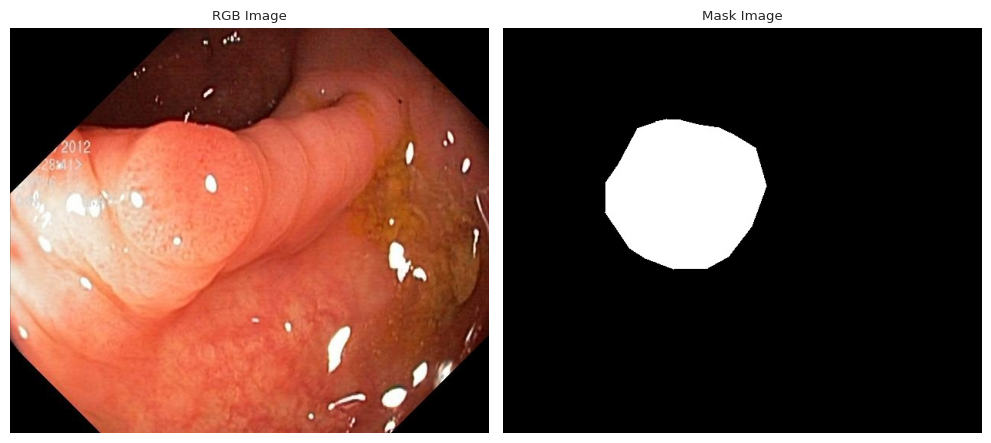

In [23]:
# Set the path to the images and masks in test directory
test_images_path = os.path.join(test_path, "images/test/")
test_images = os.listdir(test_images_path)
test_masks_path = os.path.join(test_path, "masks/test/")
test_masks = os.listdir(test_masks_path)

# Verify test mask and image sizes
print("Test Image Size: ", len(test_images))
print("Test Mask Size: ", len(test_masks))

# Read the a test image
BGR_img1 = cv2.imread(os.path.join(test_images_path, test_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read the a test mask
mask_img1 = cv2.imread(os.path.join(test_masks_path, test_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<a name="generate-validation-set"></a>
## Generate validation set

Let's split and save the validation images and masks.

In [24]:
# Iterate over the validation images and masks
for idx, p in tqdm(enumerate(valid_images), total=len(valid_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = valid_images[idx]
    mask_path = valid_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the validation image
        image = cv2.imread(image_path)
        image_path = os.path.join(valid_path, "images/valid/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the validation mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(valid_path, "masks/valid/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

  0%|          | 0/199 [00:00<?, ?it/s]

Let's have a quick look at an example of test images and masks.

Validation Image Size:  185
Validation Mask Size:  185


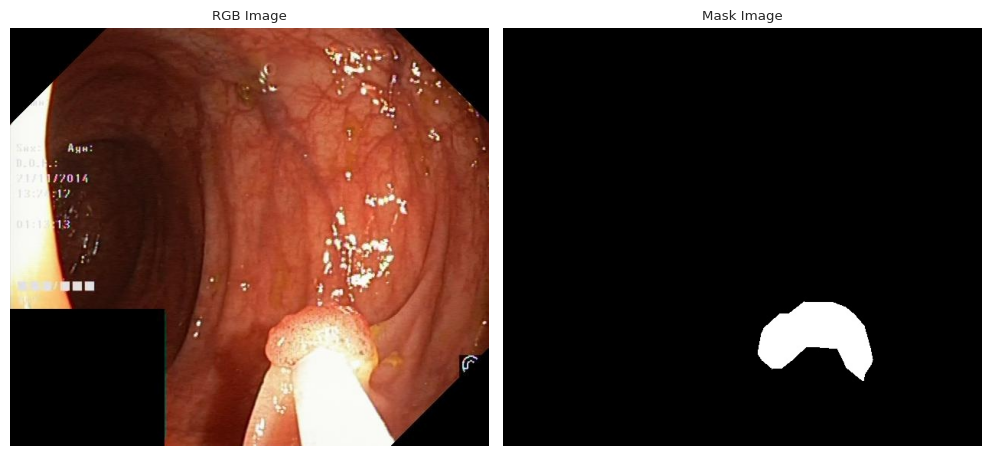

In [25]:
# Set the path to the images and masks in validation directory
valid_images_path = os.path.join(valid_path, "images/valid/")
valid_images = os.listdir(valid_images_path)
valid_masks_path = os.path.join(valid_path, "masks/valid/")
valid_masks = os.listdir(valid_masks_path)

# Verify validation mask and image sizes
print("Validation Image Size: ", len(valid_images))
print("Validation Mask Size: ", len(valid_masks))

# Read the a validation image
BGR_img1 = cv2.imread(os.path.join(valid_images_path, valid_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read the a validation mask
mask_img1 = cv2.imread(os.path.join(valid_masks_path, valid_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

<a name="generate-train-set"></a>
## Generate train set

Let's split and save the train images and masks.

In [26]:
# Iterate over the train images and masks
for idx, p in tqdm(enumerate(train_images), total=len(train_images)):
    # Extract the name of the image from the path
    name = p.split('\\')[-1].split('.')[0].split('_')[-1]

    # Get the paths for the image and mask
    image_path = train_images[idx]
    mask_path = train_masks[idx]

    # Check if the image and mask paths exist
    if os.path.exists(image_path) and os.path.exists(mask_path):
        # Read and save the train image
        image = cv2.imread(image_path)
        image_path = os.path.join(train_path, "images/train/", f"{str(name)}.jpg")
        cv2.imwrite(image_path, image)

        # Read, convert to grayscale, and save the train mask
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_path = os.path.join(train_path, "masks/train/", f"{str(name)}.jpg")
        cv2.imwrite(mask_path, mask)

  0%|          | 0/1594 [00:00<?, ?it/s]

Let's have a quick look at an example of train images and masks.

Train Image Size:  916
Train Mask Size:  916


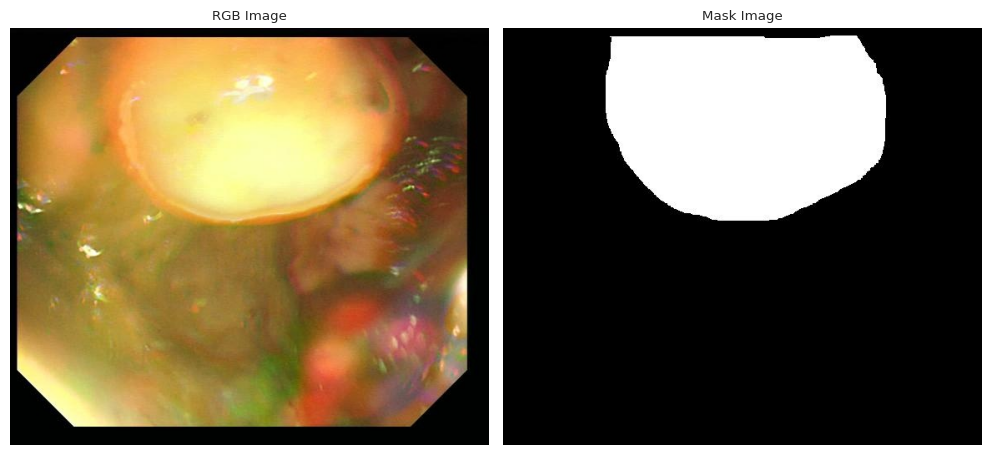

In [27]:
# Set the path to the images and masks in the train directory
train_images_path = os.path.join(train_path, "images/train/")
train_images = os.listdir(train_images_path)
train_masks_path = os.path.join(train_path, "masks/train/")
train_masks = os.listdir(train_masks_path)

# Verify train mask and image sizes
print("Train Image Size: ", len(train_images))
print("Train Mask Size: ", len(train_masks))

# Read a train image
BGR_img1 = cv2.imread(os.path.join(train_images_path, train_images[2]))

# Convert BGR image to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Read a train mask
mask_img1 = cv2.imread(os.path.join(train_masks_path, train_masks[2]))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(RGB_img1)
axs[0].set_title('RGB Image')

# Plot the mask image
axs[1].imshow(mask_img1)
axs[1].set_title('Mask Image')

# Remove the ticks and labels from both subplots
for ax in axs:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [28]:
shutil.make_archive('/content/drive/MyDrive/Classroom/Monografia/datasets/prepared_data',
                    'zip',
                    '/tmp/prepared_data')

'/content/drive/MyDrive/Classroom/Monografia/datasets/prepared_data.zip'

<a name="summary"></a>
## Summary

Now we have explored the image data as well as prepared the image dataset for image preprocessing, augmentation, and modeling in the next notebook. As a summary, we have performed the following tasks:

**Exploratory Data Analysis**
- Check image basic components
- Check image width and height
- Check polyp positions
- Check polyp size and count
- Check image hue, brightness, and saturation

**Dataset Preperation**
- Generate test set
- Generate validation set
- Generate train set